In [417]:
from IPython.display import HTML
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

<img src='Which-Customer-Service-Predictions-1200x700.png' width="700" height="300" align="center">

In [418]:
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

Recency, Frequency, Monetary Prediction 
========



**By: Pieter Leffers**

Starting Date: June 7, 2019

Completion Date: August 25, 2019

Last Updated: September 2, 2019


Summary
-----

As previously mentioned this work was inspired by [Customer Shopping Pattern Prediction: A Recurrent Neural Network Approach ](https://ieeexplore.ieee.org/document/7849921)
 by Hojjat Salehinejad and Shahryar Rahnamayan. Together they managed to put together a short,  legible, and impactful paper that inspired me to try predicting R,M,F values. Journal articles such as these need to get published more often in my opinion. Using the Ta Feng Grocery data the authors simply used the Customer ID's and past R, M, F values for their prediction which were assumed as the Customer Loyaly Numbers (CLN); provide enough information to be able to predict the (R) Recency, (F) Frequency, and (M) Monetary values one step forward in time. In their design the authors encoded the Customer IDs as dummies (or one-hot encoding), then passed the dummies along with the R,M,F values into an auto-encoder, shrinking the size of the data, before passing the data into a Simple Recurrent Neural Network for regression. In so doing the authors acheived an 80% accuracy for their model.
 



### The Ta Feng Grocery Dataset

Column definition: Transaction date and time (no timestamp), Customer ID, Age Group, PIN Code, Product subclass, Product ID, Amount, Asset, Sales price


Fields of the Dataset are:
- Transaction date and time (time invalid and useless)
- Customer ID
- Age: 10 possible values
- Residence Area: 8 possible values
- Product subclass
- Product ID
- Amount
- Asset
- Sales price

https://www.kaggle.com/chiranjivdas09/ta-feng-grocery-dataset
https://stackoverflow.com/questions/25014904/download-link-for-ta-feng-grocery-dataset


Future ideas:
1. Predicting R,F,and M values independently
2. Using multiple transactions to make a prediction
3. Make dummy variables of categories then using dimensionality reduction to pass to the network


Import Packages

In [1007]:
import pandas as pd
import numpy as np
import pickle
from datetime import date
import datetime as dt
import struct
import pylab
import pickle
import warnings
import random
import sklearn
from scipy import stats 
from scipy.stats import truncnorm
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
# Import StandardScaler 
from sklearn.preprocessing import StandardScaler

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import Input, Dense, Dropout, LSTM
from keras.layers import SimpleRNN
from keras.callbacks import EarlyStopping

from keras import regularizers
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras import optimizers

### Import and Prepare Data


In [1008]:
#Here I am importing the dictionaries I created from the exploration notebook
with open('cluster_map.pickle', 'rb') as dictionary_map1:
    cluster_map = pickle.load(dictionary_map1)

with open('age_dict_class.pickle', 'rb') as dictionary_map2:
    age_dict_class = pickle.load(dictionary_map2)
    
with open('inv_age_dict_class.pickle', 'rb') as dictionary_map3:
    inv_age_dict_class = pickle.load(dictionary_map3)
    
with open('age_dict_int.pickle', 'rb') as dictionary_map4:
    age_dict_int = pickle.load(dictionary_map4)

with open('inv_age_dict_int.pickle', 'rb') as dictionary_map5:
    inv_age_dict_int = pickle.load(dictionary_map5)
    
with open('pin_code_dict_int.pickle', 'rb') as dictionary_map6:
    pin_code_dict_int = pickle.load(dictionary_map6)
    
with open('wk_dict_int.pickle', 'rb') as dictionary_map7:
    wk_dict_int = pickle.load(dictionary_map7)

with open('age_map.pickle', 'rb') as dictionary_map8:
    age_map = pickle.load(dictionary_map8)

with open('pin_map.pickle', 'rb') as dictionary_map9:
    pin_map = pickle.load(dictionary_map9)    
    
minimized_set = pd.read_pickle("./minimized_set.pkl")
total_set = pd.read_pickle("./total_set.pkl")


In [1009]:
working_set=minimized_set[['transaction_dt','customer_id','amount','unit_price','Log_Unit_Price']]
working_set['total_sum']=working_set['amount']*working_set['unit_price']
working_set.head(3)

,transaction_dt,customer_id,amount,unit_price,Log_Unit_Price,total_sum
753166,2000-11-01,02101750,1,24.0,3.178054,24.0
787527,2000-11-01,02144511,1,55.0,4.007333,55.0
787526,2000-11-01,02144511,1,47.0,3.850148,47.0


In [1010]:
rmf_dataframe=working_set.groupby(['customer_id','transaction_dt']).sum()
rmf_dataframe['frequency']=1
rmf_dataframe['recency']=1
rmf_dataframe['monetary']=1
rmf_dataframe.head(5)

amount  unit_price  Log_Unit_Price  total_sum  \
customer_id transaction_dt                                                  
00001069    2000-11-13           2  187.000000        9.073604      187.0   
            2001-01-21           3  971.000000       17.192559      971.0   
            2001-02-03           9  283.000000       19.490021      496.0   
            2001-02-10           2  145.000000        4.976734      290.0   
00001113    2000-11-12           5  144.833333        7.544244      420.0   

                            frequency  recency  monetary  
customer_id transaction_dt                                
00001069    2000-11-13              1        1         1  
            2001-01-21              1        1         1  
            2001-02-03              1        1         1  
            2001-02-10              1        1         1  
00001113    2000-11-12              1        1         1

In [1011]:
#Find my lower and upper limit of data
lower_limit=total_set.transaction_dt.min()
upper_limit=total_set.transaction_dt.max()
#Simple function to calc difference in days
def diff_days(start_day,end_day):  
    delta = start_day - end_day
    return delta.days

### Calculate Recency, Frequency, and Monetary Values

**You may be asking why am I calculating this again?**

Because here I am doing something slightly different. For each window of time I am calculating the number of days since the previous transaction rather than the flat (snapshot) metric that I had calculated in the data exploration notebook. 

So what that means is rather than using the full snapshot in time to calculate these figures, each transaction has a changing Recency, Frequency, and Monetary value associated from the time since the customer's first purchase. In the figure below at the time of t3 the frequency would be f=2 (*I add 1 for each customer ID for being in the dataset... 0 would be no transaction*) and at the time of interest (t4) the frequency would be F=4 rather than a total of f=7.

<img src='time_intervals.png' width="700" height="300" align="center">

**Recency**

In [1012]:
ident_ticker=[0]
recency=[]
frequency=[]
monetary=[]
summer=0
counter=0

In [1013]:
for i in range(len(rmf_dataframe.index)):
    customer_id=rmf_dataframe.index[i][0]
    transaction_dt=rmf_dataframe.index[i][1].date()
    ident_ticker.append(customer_id)
    if ident_ticker[-2]!=customer_id:
        
        start_date=lower_limit.date()
        end_date=transaction_dt
        recency.append(diff_days(start_date,end_date))
    else:
        start_date=rmf_dataframe.index[i-1][1].date()
        end_date=transaction_dt
        recency.append(diff_days(start_date,end_date))
        
rmf_dataframe['recency']=recency

**Frequency**

In [1014]:
for i in range(len(rmf_dataframe.index)):
    customer_id=rmf_dataframe.index[i][0]
    transaction_dt=rmf_dataframe.index[i][1].date()
    ident_ticker.append(customer_id)
    counter+=1
    if ident_ticker[-2]!=customer_id:
        counter=1
        frequency.append(counter)
    else:
        frequency.append(counter)
        
rmf_dataframe['frequency']=frequency

**Monetary**

In [1015]:
for i in range(len(rmf_dataframe.index)):
    customer_id=rmf_dataframe.index[i][0]
    transaction_dt=rmf_dataframe.index[i][1].date()
    ident_ticker.append(customer_id)
    counter+=1
    summer+=rmf_dataframe.total_sum.values[i]
    if ident_ticker[-2]!=customer_id:
        summer=rmf_dataframe.total_sum.values[i]
        monetary.append(summer)
    else:
        monetary.append(summer)

rmf_dataframe['monetary']=monetary        

In [1016]:
rmf_df_reset=rmf_dataframe.reset_index()
rmf_df_reset.tail(10)

,customer_id,transaction_dt,amount,unit_price,Log_Unit_Price,total_sum,frequency,recency,monetary
119475,20002000,2000-12-11,23,1238.000000,65.755025,2110.0,18,-1,39920.0
119476,20002000,2000-12-12,25,564.200000,49.118044,694.0,19,-1,40614.0
119477,20002000,2000-12-13,1,100.000000,4.605170,100.0,20,-1,40714.0
119478,20002000,2000-12-14,19,632.666667,51.817422,827.0,21,-1,41541.0
119479,20002000,2000-12-15,17,1521.000000,62.716741,2232.0,22,-1,43773.0
119480,20002000,2000-12-16,28,1802.166667,91.914139,2404.0,23,-1,46177.0
119481,20002000,2000-12-17,16,469.800000,34.220278,760.0,24,-1,46937.0
119482,20002000,2000-12-18,27,485.516667,32.397747,911.0,25,-1,47848.0
119483,20002000,2001-01-20,9,1030.000000,33.862258,1075.0,26,-33,48923.0
119484,20002000,2001-02-05,6,24.000000,4.969813,72.0,27,-16,48995.0


*Create weekly values counting from the start of the dataset to the end.*

In [1017]:
#wk_set['total_sum']=wk_set['amount']*wk_set['sales_price']
rmf_df_reset['week']=[x.isocalendar()[1] for x in rmf_df_reset['transaction_dt']]
rmf_df_reset=rmf_df_reset.sort_values(by=['transaction_dt','customer_id']).reset_index(drop=True)

In [1018]:
rmf_df_reset['week_number'] = rmf_df_reset['week'].apply(lambda x: wk_dict_int[x])
rmf_df_reset=rmf_df_reset.drop('week',axis=1)
rmf_df_reset=rmf_df_reset.sort_values(by=['customer_id','week_number'])

In [1019]:
rmf_df_reset['Cluster'] = rmf_df_reset['customer_id'].apply(lambda x: cluster_map[x])
rmf_df_reset['age_int'] = rmf_df_reset['customer_id'].apply(lambda x: age_map[x])
rmf_df_reset['pin_code_int'] = rmf_df_reset['customer_id'].apply(lambda x: pin_map[x])

Below describes the average number of transactions and average number of weeks as well as the total counts in weeks. I want to make sure I capture as much data as I can for what I am about to do. We can see weeks 16 and 11 have the most transactions; also most customers have made around 6 purchases in the 4 month period of time.

*Reminder: Weeks are coded from week 0 at the start of the study time to week 17 at the end of the study time.*

In [1020]:
final_data=rmf_df_reset[['transaction_dt','customer_id','week_number','amount','total_sum','frequency','recency','monetary','Cluster','age_int','pin_code_int','unit_price','Log_Unit_Price']]
comparison=(final_data['frequency']>1)
print('Avg Frequency:',round(final_data[comparison].frequency.mean()))
print('Avg Week Number:',round(final_data[comparison].week_number.mean()))
round(final_data[comparison].week_number.value_counts())

Avg Frequency: 7
Avg Week Number: 10


16    8084
11    7803
15    6359
14    6338
13    6017
6     5976
12    5677
10    5596
5     5179
4     5127
8     5085
3     4881
9     3524
2     3463
1     3167
17    2834
7     1327
0      786
Name: week_number, dtype: int64

Here I am restricting the independant features to values prior to week 16 and the dependant features to weeks 16 or 17. So we essentially we are using transactions in the first 15 weeks to use for predicting transactions within the last two weeks. I am further restricting the dependant values to having *at least* a frequency of 1 because they need to have made a previous transaction to be considered.

In [1021]:
final_data.to_pickle('test_set.pkl')
#month leading up to the final weeks
comparison=((final_data['week_number']<=15) & (final_data['frequency']>1)) 
X_set=final_data[comparison]
#last weeks of data and has had at least 1 previous transaction 
comparison=((final_data['week_number']==16) | (final_data['week_number']==17) & (final_data['frequency']>1))
y_set=final_data[comparison]

In [1022]:
y_id_list=sorted(list(y_set.customer_id.unique()))#unique customer ids from final week

*The independant values need to have a matching customer ID in the dependent values. (there needs to be corresponding customer ID in the X and y values for regression) * 

In [1023]:
X_set=X_set.loc[X_set['customer_id'].isin(y_id_list)]#have to be represented in final week

In [1024]:
list_of_indexes = [np.argmin(g['transaction_dt']) for l, g in X_set.groupby('customer_id')]
X_set=X_set.ix[list_of_indexes]#keep only latest transaction from previous month purchases
X_set=X_set.sort_values(by=['customer_id','transaction_dt'])#sort by id
X_set=X_set.reset_index(drop=True)
print('number of unique customer ids:',len(set(list(X_set.customer_id))),'\nlength of the dataset:',len(X_set))
X_set.head()

number of unique customer ids: 6669 
length of the dataset: 6669


,transaction_dt,customer_id,week_number,amount,total_sum,frequency,recency,monetary,Cluster,age_int,pin_code_int,unit_price,Log_Unit_Price
0,2001-01-07,00005241,9,19,931.0,2,-22,1256.0,2,4,6,616.0,37.835101
1,2000-11-25,00006668,3,11,873.0,2,-14,1305.0,2,4,5,835.0,33.561764
2,2000-11-06,00010801,1,5,574.0,2,-2,663.0,2,4,5,574.0,23.360238
3,2000-11-22,00011235,3,6,425.0,2,-8,1331.0,2,11,6,425.0,24.637577
4,2000-12-11,00011914,6,13,1266.0,2,-8,1723.0,2,4,1,1113.0,44.232078


In [1025]:
X_set.tail()

,transaction_dt,customer_id,week_number,amount,total_sum,frequency,recency,monetary,Cluster,age_int,pin_code_int,unit_price,Log_Unit_Price
6664,2001-02-18,02175416,15,3,175.0,2,-10,1124.0,1,4,5,175.0,12.141534
6665,2001-02-16,02175508,15,7,197.0,2,-8,1079.0,2,1,5,153.0,16.538557
6666,2001-02-18,02176161,15,9,538.0,2,-7,1177.0,2,3,8,538.0,34.557343
6667,2001-02-15,02176185,15,13,559.0,2,-1,837.0,1,5,5,470.0,36.632623
6668,2001-02-18,02176529,15,5,616.0,2,-5,1030.0,1,2,7,571.0,19.176310


*Now restrict dependant Customer IDs to have a corresponding independant Customer ID. (y Customer IDs have a corresponding X Customer ID)*

In [1026]:
X_set_list=sorted(list(X_set.customer_id.unique()))#get list of unique ids from those represented in the last month
y_set=y_set.loc[y_set['customer_id'].isin(X_set_list)]#return only individuals who made a purchase in the prior month

In [1027]:
y_set=y_set.sort_values(by=['customer_id','transaction_dt'])
list_of_indexes = [np.argmin(g['transaction_dt']) for l, g in y_set.groupby('customer_id')]
y_set=y_set.ix[list_of_indexes]
y_set=y_set.reset_index(drop=True)
print('number of unique customer ids:',len(set(list(y_set.customer_id))),'\nlength of the dataset:',len(y_set))
y_set.head()

number of unique customer ids: 6669 
length of the dataset: 6669


,transaction_dt,customer_id,week_number,amount,total_sum,frequency,recency,monetary,Cluster,age_int,pin_code_int,unit_price,Log_Unit_Price
0,2001-02-19,00005241,16,6,315.0,4,-34,3396.0,2,4,6,267.0,19.791821
1,2001-02-22,00006668,16,2,193.0,10,-5,5099.0,2,4,5,193.0,9.101641
2,2001-02-19,00010801,16,4,161.0,15,-7,7045.0,2,4,5,161.0,14.655028
3,2001-02-27,00011235,17,7,1157.0,5,-10,4209.0,2,11,6,972.0,29.231074
4,2001-02-28,00011914,17,4,276.0,5,-53,2616.0,2,4,1,138.0,8.380457


In [1028]:
y_set.tail()

,transaction_dt,customer_id,week_number,amount,total_sum,frequency,recency,monetary,Cluster,age_int,pin_code_int,unit_price,Log_Unit_Price
6664,2001-02-19,02175416,16,9,332.0,3,-1,1456.0,1,4,5,228.0,18.584848
6665,2001-02-28,02175508,17,9,579.0,3,-12,1658.0,2,1,5,502.0,29.260515
6666,2001-02-24,02176161,16,7,473.0,3,-6,1650.0,2,3,8,473.0,28.049340
6667,2001-02-22,02176185,16,12,162.0,3,-7,999.0,1,5,5,101.0,18.496041
6668,2001-02-22,02176529,16,4,64.0,3,-4,1094.0,1,2,7,32.0,5.509388


Now we have two much smaller datasets than the original (817741), 6669 transactions for the y values (dependant) values and 6669 values for the x values (independant). Each transaction has a corresponding Customer ID in both datasets and all values in the X set should have transactions previous to those found in the y set.

In [1029]:
X_set_df=X_set[['customer_id', 'week_number', 'amount', 'total_sum', 'Cluster', 'age_int','pin_code_int','unit_price','Log_Unit_Price','frequency', 'recency', 'monetary']]#reduce Xset
y_set_df=y_set[['customer_id','frequency','recency','monetary']]#reduce yset

In [1030]:
X_set_df.to_pickle('X_set_df.pkl')
y_set_df.to_pickle('y_set_df.pkl')

_____________________________

In [1031]:
with open('X_set_df.pkl', 'rb') as fp:
     X_set_df = pickle.load(fp)
with open('y_set_df.pkl', 'rb') as fp:
     y_set_df = pickle.load(fp)

In [1032]:
X_set_df.head(3)

,customer_id,week_number,amount,total_sum,Cluster,age_int,pin_code_int,unit_price,Log_Unit_Price,frequency,recency,monetary
0,00005241,9,19,931.0,2,4,6,616.0,37.835101,2,-22,1256.0
1,00006668,3,11,873.0,2,4,5,835.0,33.561764,2,-14,1305.0
2,00010801,1,5,574.0,2,4,5,574.0,23.360238,2,-2,663.0


In [1033]:
y_set_df.head(3)

,customer_id,frequency,recency,monetary
0,00005241,4,-34,3396.0
1,00006668,10,-5,5099.0
2,00010801,15,-7,7045.0


_________________

Full Model
===

Here I am choosing to use, in a way, the simplest method; just pass the features that I feel could help to possibly inform the prediction along with split values of Customer ID and R,M,F values. *(Let's call it the kitchen sink approach)* These values are passed into a function below that splits the Customer IDs into seperate integer values, just in case there truly are features within the Customer ID that can inform RFM prediction.

*Note: I didn't include date for obvious reasons.*

In [1034]:
def return_pair(df,indexer=0):
    '''
    Splits the Customer ID into integers and places other values alongside in the array.
    '''
    data=df.iloc[indexer]
    x=[]
    part1=list(map(int,list(data.iloc[0])))
    part2=list(data.iloc[1:])
    x.extend(part1)
    x.extend(part2)
    x=np.array(x)
    return x

In [1035]:
X_set=np.array([return_pair(X_set_df,i) for i in range(0,len(X_set_df))])
#X_set=np.array(X_set.values)

In [1036]:
X_set[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        5.00000000e+00,  2.00000000e+00,  4.00000000e+00,  1.00000000e+00,
        9.00000000e+00,  1.90000000e+01,  9.31000000e+02,  2.00000000e+00,
        4.00000000e+00,  6.00000000e+00,  6.16000000e+02,  3.78351009e+01,
        2.00000000e+00, -2.20000000e+01,  1.25600000e+03])

In [1037]:
y_set=np.array([return_pair(y_set_df,i) for i in range(0,len(y_set_df))])
#y_set=np.array(y_set.values)

In [1038]:
y_set[0]

array([ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  5.000e+00,
        2.000e+00,  4.000e+00,  1.000e+00,  4.000e+00, -3.400e+01,
        3.396e+03])

In [1039]:
n_orig_size=len(X_set)
n_train_percent = round(n_orig_size*.2)
print('Original size:',n_orig_size,'\n20 Percent of size:',n_train_percent)

Original size: 6669 
20 Percent of size: 1334


**Split into Training and Test sets**

*80/20 split*

In [1040]:
train_X=X_set[n_train_percent:,:]
train_y=y_set[n_train_percent:,:]
test_X=X_set[:n_train_percent, :]
test_y=y_set[:n_train_percent, :]

In [1041]:
train_X.shape,test_X.shape

((5335, 19), (1334, 19))

In [1042]:
train_y.shape,test_y.shape

((5335, 11), (1334, 11))

**Normalize the X,y sets**

Both sets have values on different scales.

In [1043]:
scaler_y = MinMaxScaler(feature_range=(0, 1))
train_y = scaler_y.fit_transform(train_y)
test_y = scaler_y.fit_transform(test_y)

In [1044]:
scaler_x = MinMaxScaler(feature_range=(0, 1))
rescaled_x_train = scaler_x.fit_transform(train_X)
rescaled_x_test = scaler_x.fit_transform(test_X)

Return array shapes because it matters..

In [1045]:
# reshape input to be 3D [samples, timesteps, features]
train_X = rescaled_x_train.reshape((rescaled_x_train.shape[0], 1, rescaled_x_train.shape[1]))
test_X = rescaled_x_test.reshape((rescaled_x_test.shape[0], 1, rescaled_x_test.shape[1]))
print('train_X',train_X.shape,'\ntrain_y', train_y.shape,'\ntest_X', test_X.shape,'\ntest_y', test_y.shape)
 

train_X (5335, 1, 19) 
train_y (5335, 11) 
test_X (1334, 1, 19) 
test_y (1334, 11)


### Hyperperameters

    1. SimpleRNN
    2. Relu activation
    3. 250 hidden units
    4. L1 regularization at 0.0001
    5. MSE loss
    6. Batch size 120
    7. Shuffle=True
    8. 1000 epochs

The hyperperameter options are pretty similar to the ones mentioned in the 'Customer Shopping Pattern Prediction' paper. I think the only difference is I'm using the all so popular Adam optimizer as opposed to SGD. Since Adam is based on SGD I think its a narrow distinction. I get better results with Adam.

In [1046]:
epochs = 1000
learning_rate = 0.001
model = Sequential()
model.add(SimpleRNN(19,activation='relu',input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(250,kernel_initializer='random_uniform', activity_regularizer=regularizers.l1(0.0001)))
model.add(Dense(11))
model.compile(loss='mse', optimizer='adam', metrics=['mae', 'acc'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_19 (SimpleRNN)    (None, 19)                741       
_________________________________________________________________
dense_37 (Dense)             (None, 250)               5000      
_________________________________________________________________
dense_38 (Dense)             (None, 11)                2761      
Total params: 8,502
Trainable params: 8,502
Non-trainable params: 0
_________________________________________________________________


In [1047]:
%%capture captured

# fit network
history = model.fit(train_X, train_y, epochs=epochs, batch_size=120, validation_data=(test_X, test_y), validation_split=0.3, verbose=1, shuffle=True)

In [1048]:
file_out=captured.stdout

In [1049]:
print(file_out[-20000:])

5335/5335 [==============================] - 0s 79us/step - loss: 0.0039 - mean_absolute_error: 0.0209 - acc: 0.7604 - val_loss: 0.0045 - val_mean_absolute_error: 0.0234 - val_acc: 0.7751
Epoch 991/1000
5335/5335 [==============================] - 0s 77us/step - loss: 0.0040 - mean_absolute_error: 0.0215 - acc: 0.7575 - val_loss: 0.0044 - val_mean_absolute_error: 0.0230 - val_acc: 0.7901
Epoch 992/1000
5335/5335 [==============================] - 0s 76us/step - loss: 0.0040 - mean_absolute_error: 0.0208 - acc: 0.7573 - val_loss: 0.0045 - val_mean_absolute_error: 0.0241 - val_acc: 0.7736
Epoch 993/1000
5335/5335 [==============================] - 0s 76us/step - loss: 0.0039 - mean_absolute_error: 0.0208 - acc: 0.7595 - val_loss: 0.0046 - val_mean_absolute_error: 0.0260 - val_acc: 0.7579
Epoch 994/1000
5335/5335 [==============================] - 0s 82us/step - loss: 0.0040 - mean_absolute_error: 0.0230 - acc: 0.7584 - val_loss: 0.0044 - val_mean_absolute_error: 0.0235 - val_acc: 0.7676


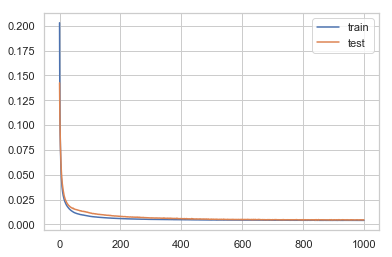

In [1050]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [1051]:
yhat = model.predict(test_X)
yhat.shape

(1334, 11)

In [1052]:
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])
test_X.shape

(1334, 19)

In [1053]:
inv_yhat = concatenate((scaler_x.inverse_transform(test_X), scaler_y.inverse_transform(yhat)),axis=1)
inv_y = concatenate((scaler_x.inverse_transform(test_X),scaler_y.inverse_transform(test_y)), axis=1)

In [1054]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[0], inv_yhat[0]))
print('Test RMSE (Prediction): %.3f' % rmse)

Test RMSE (Prediction): 613.826


In [1055]:
indexer=10
transformed_id=[''.join(list(map(str,list(map(int,list(scaler_x.inverse_transform(test_X)[indexer][:-11]))))))]
week_number=[scaler_x.inverse_transform(test_X)[indexer][-11]]
amount=[scaler_x.inverse_transform(test_X)[indexer][-10]]
total_sum=[scaler_x.inverse_transform(test_X)[indexer][-9]]

cluster=[scaler_x.inverse_transform(test_X)[indexer][-8]]
age=[scaler_x.inverse_transform(test_X)[indexer][-7]]
pin=[scaler_x.inverse_transform(test_X)[indexer][-6]]
unit_price=[scaler_x.inverse_transform(test_X)[indexer][-5]]
log_unit_price=[scaler_x.inverse_transform(test_X)[indexer][-4]]

In [1056]:
prediction=list(scaler_y.inverse_transform(yhat)[:, -3:][indexer])

### Input (Training)

In [1057]:
input_set=pd.DataFrame((transformed_id+week_number+amount+total_sum+cluster+pin+age+unit_price+log_unit_price)).T.copy()
input_set.columns=['ID','Week_number','Amount','Total_sum','Cluster','Age_group','Pin_code','Unit_price','Log_unit_price']
input_set

,ID,Week_number,Amount,Total_sum,Cluster,Age_group,Pin_code,Unit_price,Log_unit_price
0,00020220,1,29,1444,2,6,5,1388,101.706


### Training R,F,M Values


In [1058]:
outputID=input_set['ID'][0]
comparison=X_set_df['customer_id']==outputID
X_set_df[comparison][['frequency','recency','monetary']]

,frequency,recency,monetary
10,2,-2,4023.0


### Prediction

In [1059]:
output_set=pd.DataFrame((prediction)).T.copy()
output_set.columns=['frequency','recency','monetary']
output_set

,frequency,recency,monetary
0,8.368375,-20.723309,24180.847656


### True value

In [1060]:
comparison=y_set_df['customer_id']==outputID
y_set_df[comparison][['frequency','recency','monetary']]

,frequency,recency,monetary
10,17,-13,22605.0


_______________

Reduced Model
===

Here I am choosing to reduce the training set down to just the Customer ID's and the R,M,F values in order to compare the results when I just have the bare minimum of features. In all other respects the model is entirely the same. 

In [1061]:
X_set_df=X_set_df[['customer_id','frequency','recency','monetary']]#reduce Xset
y_set_df=y_set_df[['customer_id','frequency','recency','monetary']]#reduce yset

In [1062]:
X_set_df.head(3)

,customer_id,frequency,recency,monetary
0,00005241,2,-22,1256.0
1,00006668,2,-14,1305.0
2,00010801,2,-2,663.0


In [1063]:
y_set_df.head(3)

,customer_id,frequency,recency,monetary
0,00005241,4,-34,3396.0
1,00006668,10,-5,5099.0
2,00010801,15,-7,7045.0


In [1064]:
X_set=np.array([return_pair(X_set_df,i) for i in range(0,len(X_set_df))])
X_set[0]

array([ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  5.000e+00,
        2.000e+00,  4.000e+00,  1.000e+00,  2.000e+00, -2.200e+01,
        1.256e+03])

In [1065]:
y_set=np.array([return_pair(y_set_df,i) for i in range(0,len(y_set_df))])
y_set[0]

array([ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  5.000e+00,
        2.000e+00,  4.000e+00,  1.000e+00,  4.000e+00, -3.400e+01,
        3.396e+03])

In [1066]:
n_orig_size=len(X_set)
n_train_percent = round(n_orig_size*.2)
print('Original size:',n_orig_size,'\n20 Percent of size:',n_train_percent)

Original size: 6669 
20 Percent of size: 1334


In [1067]:
train_X=X_set[n_train_percent:,:]
train_y=y_set[n_train_percent:,:]
test_X=X_set[:n_train_percent, :]
test_y=y_set[:n_train_percent, :]

In [1068]:
train_X.shape,test_X.shape

((5335, 11), (1334, 11))

In [1069]:
train_y.shape,test_y.shape

((5335, 11), (1334, 11))

In [1070]:
scaler_y = MinMaxScaler(feature_range=(0, 1))
train_y = scaler_y.fit_transform(train_y)
test_y = scaler_y.fit_transform(test_y)

In [1071]:
scaler_x = MinMaxScaler(feature_range=(0, 1))
rescaled_x_train = scaler_x.fit_transform(train_X)
rescaled_x_test = scaler_x.fit_transform(test_X)

In [1072]:
# reshape input to be 3D [samples, timesteps, features]
train_X = rescaled_x_train.reshape((rescaled_x_train.shape[0], 1, rescaled_x_train.shape[1]))
test_X = rescaled_x_test.reshape((rescaled_x_test.shape[0], 1, rescaled_x_test.shape[1]))
print('train_X',train_X.shape,'\ntrain_y', train_y.shape,'\ntest_X', test_X.shape,'\ntest_y', test_y.shape)
 

train_X (5335, 1, 11) 
train_y (5335, 11) 
test_X (1334, 1, 11) 
test_y (1334, 11)


In [1073]:
epochs = 1000
learning_rate = 0.001
model = Sequential()
model.add(SimpleRNN(11,activation='relu',input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(250,kernel_initializer='random_uniform', activity_regularizer=regularizers.l1(0.0001)))
model.add(Dense(11))
model.compile(loss='mse', optimizer='adam', metrics=['mae', 'acc'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_20 (SimpleRNN)    (None, 11)                253       
_________________________________________________________________
dense_39 (Dense)             (None, 250)               3000      
_________________________________________________________________
dense_40 (Dense)             (None, 11)                2761      
Total params: 6,014
Trainable params: 6,014
Non-trainable params: 0
_________________________________________________________________


In [1074]:
%%capture captured

# fit network
history = model.fit(train_X, train_y, epochs=epochs, batch_size=120, validation_data=(test_X, test_y), validation_split=0.3, verbose=1, shuffle=True)

In [1075]:
file_out=captured.stdout
print(file_out[-20000:])

5335/5335 [==============================] - 0s 83us/step - loss: 0.0048 - mean_absolute_error: 0.0245 - acc: 0.7496 - val_loss: 0.0098 - val_mean_absolute_error: 0.0479 - val_acc: 0.7211
Epoch 991/1000
5335/5335 [==============================] - 0s 84us/step - loss: 0.0048 - mean_absolute_error: 0.0236 - acc: 0.7413 - val_loss: 0.0100 - val_mean_absolute_error: 0.0491 - val_acc: 0.7264
Epoch 992/1000
5335/5335 [==============================] - 0s 81us/step - loss: 0.0048 - mean_absolute_error: 0.0240 - acc: 0.7471 - val_loss: 0.0100 - val_mean_absolute_error: 0.0502 - val_acc: 0.6942
Epoch 993/1000
5335/5335 [==============================] - 0s 84us/step - loss: 0.0049 - mean_absolute_error: 0.0261 - acc: 0.7445 - val_loss: 0.0098 - val_mean_absolute_error: 0.0473 - val_acc: 0.6897
Epoch 994/1000
5335/5335 [==============================] - 0s 83us/step - loss: 0.0048 - mean_absolute_error: 0.0234 - acc: 0.7430 - val_loss: 0.0100 - val_mean_absolute_error: 0.0486 - val_acc: 0.7151


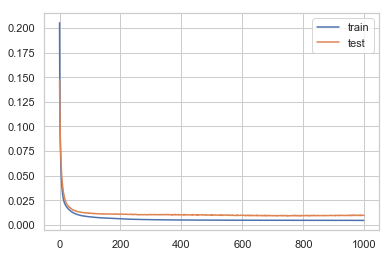

In [1076]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [1077]:
yhat = model.predict(test_X)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])

In [1078]:
inv_yhat = concatenate((scaler_x.inverse_transform(test_X), scaler_y.inverse_transform(yhat)),axis=1)
inv_y = concatenate((scaler_x.inverse_transform(test_X),scaler_y.inverse_transform(test_y)), axis=1)

In [1079]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[0], inv_yhat[0]))
print('Test RMSE (Prediction): %.3f' % rmse)

Test RMSE (Prediction): 934.476


In [1080]:
indexer=10
transformed_id=[''.join(list(map(str,list(map(int,list(scaler_x.inverse_transform(test_X)[indexer][:-3]))))))]
prediction=list(scaler_y.inverse_transform(yhat)[:, -3:][indexer])

### Prediction

In [1081]:
output=pd.DataFrame((transformed_id+prediction)).T.copy()
output.columns=['ID','Recency','Freqency','Monetary']
output

,ID,Recency,Freqency,Monetary
0,00020220,8.04615,-20.9094,15129.2


### Training

In [1082]:
outputID=output['ID'][0]
comparison=X_set_df['customer_id']==outputID
X_set_df[comparison]

,customer_id,frequency,recency,monetary
10,00020220,2,-2,4023.0


### True value

In [1083]:
comparison=y_set_df['customer_id']==outputID
y_set_df[comparison]

,customer_id,frequency,recency,monetary
10,00020220,17,-13,22605.0


Interpretation
------

____________________

After running both models we see some surprising results! Firstly, I am surprised at how well the Simple RNN model is able to figure out the relationships with sequences with such little information (Reduced Model and Journal Article). From the start I get at least a 70% accuracy without the use any dimensionality reduction techniques. 

I after comparing the Full and Reduced models I think we can make some simple conclusions: 

 1. Very little of the model is informed by the inclusion of all the additional features (Week_number, Amount, 	Total_sum, Cluster, Age_group, Pin_code, Unit_price, Log_unit_price); a fact that I find surprising alone. The only benefit to the model by adding the other features is perhaps a reduced Root Means Squared Error for prediction.
    
 2. Using very few previous transactions you can predict the R,F,M values at at least a 70% accuracy. Of course, if I were trying to build a model to diagnose cancer I'd probably throw it away and go back to formula, but since we are probably dealing with advertising and promotions I feel 70% is plenty accurate to decide to provide a 20% discount to regular shoppers at Bath and Bodyworks (*we all know it to be true*).